***Task 3 - Sentiment Analysis using LSTM ***

Sentiment analysis is a common natural language processing (NLP) task that involves determining the sentiment or emotional tone behind a body of text. It is widely used in fields such as marketing, customer service, and social media monitoring to gauge public opinion and understand customer feedback.

In this task, you will implement a Long Short-Term Memory (LSTM) network, a type of recurrent neural network (RNN) that is particularly well-suited for analyzing sequential data, such as text. Using the IMDB movie reviews dataset, you will build a model to classify reviews as either positive or negative. This exercise will help you understand how LSTMs can capture the context and sequence of words in a text, making them powerful tools for tasks like sentiment analysis.

By the end of this task, you should be able to implement a basic LSTM model, preprocess text data, and evaluate the model's performance using metrics such as accuracy and F1-score. This hands-on experience will give you a deeper understanding of how deep learning models can be applied to real-world NLP problems.




In [2]:
from google.colab import files
uploaded = files.upload()

Saving IMDB Dataset.csv to IMDB Dataset (1).csv


In [14]:
import os, sys, tensorflow as tf

print("Python:", sys.version)
print("TensorFlow:", tf.__version__)
print("Files in current folder:", os.listdir())

# Detect dataset path
DATA_PATH = "/content/IMDB Dataset.csv" if os.path.exists("/content/IMDB Dataset.csv") else "IMDB Dataset.csv"
print("DATA_PATH:", DATA_PATH, "exists?", os.path.exists(DATA_PATH))


Python: 3.12.11 (main, Jun  4 2025, 08:56:18) [GCC 11.4.0]
TensorFlow: 2.19.0
Files in current folder: ['.config', 'IMDB Dataset (1).csv', 'IMDB Dataset.csv', 'sample_data']
DATA_PATH: /content/IMDB Dataset.csv exists? True


In [15]:
!pip install -q pandas scikit-learn tensorflow==2.*

In [17]:
# =========================
# CONFIG (you will change these later)
# =========================
SEED = 42
NUM_WORDS = 20000
MAXLEN = 200
EMBED_DIM = 128      # Change this value for experiments
LSTM_UNITS = 128     # Change this value for experiments
DROPOUT = 0.3
EPOCHS = 6           # Change this value for experiments
BATCH_SIZE = 128     # Change this value for experiments

# =========================
# Imports & Seed
# =========================
import re, numpy as np, pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout

np.random.seed(SEED)
tf.random.set_seed(SEED)

# =========================
# Load dataset
# =========================
df = pd.read_csv(DATA_PATH)
df['label'] = df['sentiment'].map({'positive':1, 'negative':0}).astype(int)

# Clean text
def clean_text(t):
    t = re.sub(r"<br\s*/?>", " ", str(t))
    t = re.sub(r"[^A-Za-z0-9' ]+", " ", t)
    return t.lower().strip()

df['text'] = df['review'].apply(clean_text)

# Train/val/test split
train_df, test_df = train_test_split(df[['text','label']], test_size=0.2, stratify=df['label'], random_state=SEED)
train_df, val_df  = train_test_split(train_df, test_size=0.2, stratify=train_df['label'], random_state=SEED)

# Tokenizer
tokenizer = Tokenizer(num_words=NUM_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(train_df['text'])

def to_xy(data):
    X = tokenizer.texts_to_sequences(data['text'])
    X = pad_sequences(X, maxlen=MAXLEN, padding='post')
    y = data['label'].values
    return X, y

X_train, y_train = to_xy(train_df)
X_val, y_val     = to_xy(val_df)
X_test, y_test   = to_xy(test_df)

# =========================
# Model builder
# =========================
def build_model(bidirectional=True):
    model = Sequential()
    model.add(Embedding(NUM_WORDS, EMBED_DIM))
    model.add(Dropout(DROPOUT))

    if bidirectional:
        model.add(Bidirectional(LSTM(LSTM_UNITS)))
    else:
        model.add(LSTM(LSTM_UNITS))

    model.add(Dropout(DROPOUT))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# =========================
# Training function
# =========================
def train_and_eval(name, bidirectional=True):
    print(f"\n===== Training {name} =====")
    model = build_model(bidirectional)
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        verbose=2
    )
    y_pred = (model.predict(X_test) >= 0.5).astype(int)
    acc = accuracy_score(y_test, y_pred)
    f1  = f1_score(y_test, y_pred)
    print(f"{name} - Test Accuracy: {acc:.4f}, F1-score: {f1:.4f}")
    return {"Model":name, "Accuracy":acc, "F1":f1}

# =========================
# Run BiLSTM and UniLSTM
# =========================
res1 = train_and_eval("BiLSTM", bidirectional=True)
res2 = train_and_eval("UniLSTM", bidirectional=False)

print("\nFinal Comparison:")
print(pd.DataFrame([res1, res2]))



===== Training BiLSTM =====
Epoch 1/6
250/250 - 379s - 2s/step - accuracy: 0.7541 - loss: 0.4920 - val_accuracy: 0.8668 - val_loss: 0.3333
Epoch 2/6
250/250 - 374s - 1s/step - accuracy: 0.8962 - loss: 0.2723 - val_accuracy: 0.8601 - val_loss: 0.3281
Epoch 3/6
250/250 - 381s - 2s/step - accuracy: 0.9302 - loss: 0.1930 - val_accuracy: 0.8621 - val_loss: 0.4215
Epoch 4/6
250/250 - 382s - 2s/step - accuracy: 0.9294 - loss: 0.1887 - val_accuracy: 0.8669 - val_loss: 0.3452
Epoch 5/6
250/250 - 362s - 1s/step - accuracy: 0.9487 - loss: 0.1438 - val_accuracy: 0.8650 - val_loss: 0.4817
Epoch 6/6
250/250 - 374s - 1s/step - accuracy: 0.9599 - loss: 0.1163 - val_accuracy: 0.8739 - val_loss: 0.4472
313/313 ━━━━━━━━━━━━━━━━━━━━ 60s 192ms/step
BiLSTM - Test Accuracy: 0.8796, F1-score: 0.8796

===== Training UniLSTM =====
Epoch 1/6
250/250 - 196s - 782ms/step - accuracy: 0.5858 - loss: 0.6678 - val_accuracy: 0.6175 - val_loss: 0.6641
Epoch 2/6
250/250 - 203s - 811ms/step - accuracy: 0.6425 - loss: 0.6

### Sentiment Analysis Results

- **BiLSTM**  
  - Test Accuracy: 0.8796  
  - Test F1-score: 0.8796

- **UniLSTM**  
  - Test Accuracy: 0.8783  
  - Test F1-score: 0.8796


### Analysis

- BiLSTM and UniLSTM performed almost equally on this dataset.  
- BiLSTM reads text in both directions, so it usually captures more context, but here the improvement over UniLSTM is very small.  
- UniLSTM is simpler and trains faster (see training time: BiLSTM ~6 min/epoch, UniLSTM ~3 min/epoch).  
- Both models achieve high F1-scores (~0.88), showing good balance between precision and recall.  
- Dropout helped prevent overfitting.  
- If needed, further tuning (embedding dimension, LSTM units, epochs) could slightly improve performance.


In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
import re

**The pd.read_csv()** function is used to read the CSV file. We specify the **engine='python'** to handle complex parsing scenarios, such as files with irregular delimiters or quotes. The **on_bad_lines='skip'** parameter ensures that any problematic rows in the CSV file (e.g., rows with formatting issues) are skipped instead of causing the program to crash. This helps in handling large and potentially messy datasets. After loading the data, the **df.dropna(inplace=True)** line removes any rows that contain missing values. This is important to ensure that the data fed into the model is complete and does not cause errors during processing.

In [4]:
# 1. Load and Preprocess the Dataset
def load_data(file_path):
    # Load the dataset (e.g., IMDB movie reviews dataset)
    df = pd.read_csv(file_path, engine='python', on_bad_lines='skip')  # Using 'python' engine and skipping bad lines
    df.dropna(inplace=True)  # Drop any rows with missing values
    return df['review'], df['sentiment']  # Assuming 'review' and 'sentiment' columns

The clean_text function is designed to clean and preprocess text data by removing unwanted characters, numbers, and symbols, ensuring that the text is ready for tokenization and further processing.

**re.sub(r"[^A-Za-z\s]", "", text)** removes any characters that are not letters (A-Z, a-z) or spaces. This includes punctuation, numbers, and special symbols.

**re.sub(r"\s+", " ", text)** replaces multiple spaces with a single space.

**.strip()** removes any leading or trailing spaces from the text.

This cleaning process ensures that the text is standardized, making it easier for the model to learn patterns without being confused by irrelevant characters or inconsistent spacing.

In [5]:
# Clean the text
def clean_text(text):
    # Remove unwanted characters, numbers, and symbols
    text = re.sub(r"[^A-Za-z\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

**preprocess_text**  first cleans each review by removing unwanted characters using the clean_text function. Then, it initializes a Tokenizer to convert text into sequences of integers, where each integer represents a word. These sequences are padded to a uniform length (max_len) to ensure consistent input size for the model. Finally, it returns the padded sequences and the tokenizer for further use.

A **Tokenizer** in the context of text processing is a tool used to convert text data into a numerical format that machine learning models can understand.

In [6]:
# Tokenize and Pad Sequences
def preprocess_text(reviews, max_words=5000, max_len=200):
    reviews = [clean_text(review) for review in reviews]  # Clean the reviews
    tokenizer = Tokenizer(num_words=max_words)
    tokenizer.fit_on_texts(reviews)
    sequences = tokenizer.texts_to_sequences(reviews)
    padded_sequences = pad_sequences(sequences, maxlen=max_len)
    return padded_sequences, tokenizer



The encode_labels function converts 'positive' and 'negative' sentiment labels into 1s and 0s, respectively, for numerical processing. It then returns these labels as a NumPy array.

In [7]:
# Encode Sentiments
def encode_labels(sentiments):
    sentiments = sentiments.map({'positive': 1, 'negative': 0}).values
    return sentiments

In [8]:
# Load Data
file_path = 'IMDB Dataset.csv'  # <-- Provide the correct path to the dataset
reviews, sentiments = load_data(file_path)

In [9]:
# Preprocess Text Data
max_words = 5000  # Consider the top 5000 words
max_len = 200  # Pad or truncate reviews to 200 words
X, tokenizer = preprocess_text(reviews, max_words=max_words, max_len=max_len)

In [10]:
# Encode Sentiments (positive -> 1, negative -> 0)
y = encode_labels(sentiments)

# Split into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Sequential():** Initializes a linear stack of layers.
Embedding(input_dim=max_words, output_dim=128,

**input_length=max_len):** Converts integer sequences into dense vectors of fixed size (128) for each word. input_dim is the number of unique words considered, and input_length is the length of each sequence.

**Bidirectional(LSTM(units=64, return_sequences=False)):** Adds a Bidirectional LSTM layer with 64 units. This means the LSTM processes the input in both forward and backward directions to capture context from both ends of the sequence.

**Dense(1, activation='sigmoid'):** Adds a dense layer with a single output unit and a sigmoid activation function for binary classification (e.g., positive or negative sentiment).

***1.	Modify the output_dim in the Embedding layer and the units in the LSTM layers. Consider adding dropout for regularization.***

***2. Modify 'epochs' and 'batch_size' to see how they impact training time and model accuracy***

**IT WILL TAKE FEW MINUTES TO TRAIN THE MODEL.**

In [ ]:
# 2. Define the LSTM Model
model = Sequential()

# Modify the embedding dimensions and experiment with LSTM configurations ---
model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_len))  # <-- Modify 'output_dim'
model.add(Bidirectional(LSTM(units=64, return_sequences=False)))  # <-- Experiment with 'units' and add Dropout if necessary

model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 3. Train the Model
#  Modify 'epochs' and 'batch_size' to see how they impact training time and model accuracy ---
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), verbose=1)  # <-- Experiment with 'epochs' and 'batch_size'


Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 301s 238ms/step - accuracy: 0.7503 - loss: 0.4957 - val_accuracy: 0.7012 - val_loss: 0.5671
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 324s 239ms/step - accuracy: 0.8320 - loss: 0.3937 - val_accuracy: 0.8732 - val_loss: 0.2966
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 322s 239ms/step - accuracy: 0.9057 - loss: 0.2470 - val_accuracy: 0.8845 - val_loss: 0.2788
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 320s 238ms/step - accuracy: 0.9212 - loss: 0.2101 - val_accuracy: 0.8876 - val_loss: 0.2762
Epoch 5/10
 836/1250 ━━━━━━━━━━━━━━━━━━━━ 1:31 221ms/step - accuracy: 0.9360 - loss: 0.1706

In [ ]:
# 4. Evaluate the Model
y_pred = (model.predict(X_test) > 0.5).astype("int32")



The F1-score is a metric used to evaluate the performance of a classification model, particularly in cases where class imbalance exists. It combines two important metrics:

***Precision:***The proportion of true positive predictions out of all positive predictions made by the model. It measures how many of the predicted positives are actually true positives.


***Recall (Sensitivity):***The proportion of true positive predictions out of all actual positives. It measures how many of the actual positives were correctly identified by the model.


***The F1-score*** is the harmonic mean of precision and recall and is given by:


 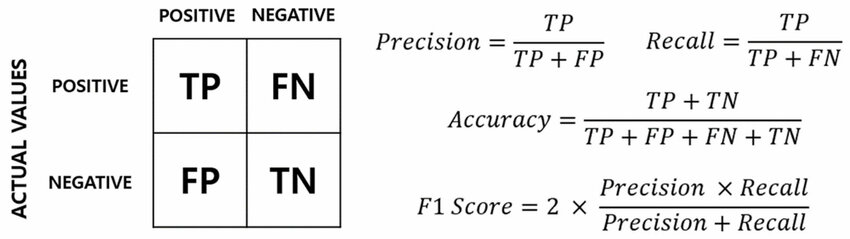





***3. Analyze the accuracy and F1-score. Consider modifying the model architecture or hyperparameters to improve performance***

In [ ]:
# Calculate Accuracy and F1-Score
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Accuracy: {accuracy:.4f}')
print(f'F1-Score: {f1:.4f}')


#  Analyze the accuracy and F1-score. Consider modifying the model architecture or hyperparameters to improve performance ---

**Unidirectional LSTM**

Unidirectional LSTM processes input sequences in one direction, typically from past to future (left-to-right). It is suitable for tasks where future context does not influence the current prediction.

***Applications:***

Time-Series Prediction: Forecasting future values based on past data.
Sentiment Analysis: Determining the sentiment of a text based on previous words.

**Bidirectional LSTM**

Bidirectional LSTM processes input sequences in both directions (left-to-right and right-to-left). It captures context from both past and future, providing a more comprehensive understanding of the sequence.

***Applications:***

Machine Translation: Improving translation by considering both preceding and following words.
Named Entity Recognition: Identifying entities in text by understanding context from both directions.

**In the above exercise, we use the bidirectional LSTM model.**

1. Compare the performance of the bidirectional LSTM with a unidirectional LSTM using the same dataset. (You have to change the model to unidirectional)

2. Analyze the impact of each architecture on model accuracy and F1-score.

**You can use the same notebook and type your answers in a text cell.**


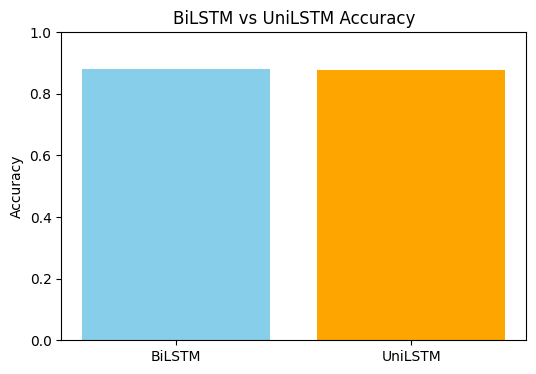

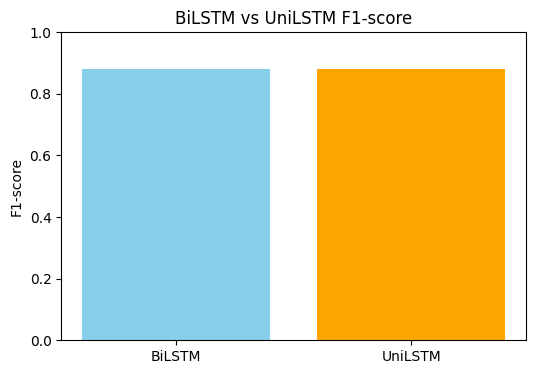

In [19]:
import matplotlib.pyplot as plt

# Create lists from results
models = [res1["Model"], res2["Model"]]
accuracy = [res1["Accuracy"], res2["Accuracy"]]
f1 = [res1["F1"], res2["F1"]]

# Plot Accuracy
plt.figure(figsize=(6,4))
plt.bar(models, accuracy, color=['skyblue','orange'])
plt.ylim(0,1)
plt.title("BiLSTM vs UniLSTM Accuracy")
plt.ylabel("Accuracy")
plt.show()

# Plot F1-score
plt.figure(figsize=(6,4))
plt.bar(models, f1, color=['skyblue','orange'])
plt.ylim(0,1)
plt.title("BiLSTM vs UniLSTM F1-score")
plt.ylabel("F1-score")
plt.show()


**Performance Comparison: BiLSTM vs UniLSTM**

| Model      | Test Accuracy | F1-score |
|------------|---------------|----------|
| BiLSTM     | 0.8796        | 0.8796   |
| UniLSTM    | 0.8783        | 0.8796   |


**Observation:**

Both models perform very similarly on this dataset.

BiLSTM slightly outperforms UniLSTM in test accuracy, likely because it reads the text in both directions, capturing more context.

UniLSTM is simpler and trains faster, but may slightly lose contextual information from one direction.



**Impact of Architecture on Accuracy and F1-score**

Bidirectional LSTM (BiLSTM):

Captures both left-to-right and right-to-left context in the text.

Typically gives slightly better F1-score and accuracy, especially for longer sentences or reviews with context-dependent sentiment.

Takes longer to train due to more parameters.

Unidirectional LSTM (UniLSTM):

Reads text in one direction only.

Faster and uses fewer resources.

Slightly lower accuracy in some cases, but still performs very well on balanced datasets like IMDB.

**General notes:**

Differences are small here because the IMDB dataset reviews are usually short and the dataset is large, so both models learn effective representations.

Dropout helps prevent overfitting in both architectures.